In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../Data/PCEPersonalSpending.csv', index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [3]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [5]:
df = df.dropna()
len(df)

252

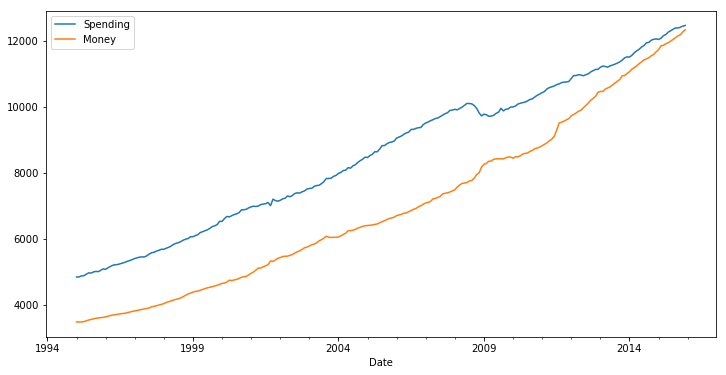

In [7]:
df['Spending'].plot(figsize=(12, 6), legend=True)
df['Money'].plot(legend=True)

#### Test for Stationarity

In [8]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
adf_test(df['Money'], title='Money')

Augmented Dickey-Fuller Test: Money
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [10]:
adf_test(df['Spending'], title='Spending')

Augmented Dickey-Fuller Test: Spending
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [12]:
df_transformed = df.diff()
df_transformed = df_transformed.dropna()

In [13]:
adf_test(df_transformed['Money'], title='MoneyFirstDiff')

Augmented Dickey-Fuller Test: MoneyFirstDiff
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [14]:
adf_test(df_transformed['Spending'], title='SpendingFirstDiff')

Augmented Dickey-Fuller Test: SpendingFirstDiff
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [15]:
df_transformed = df_transformed.diff().dropna()

In [16]:
adf_test(df_transformed['Money'], title='MoneySecondDiff')
print()
adf_test(df_transformed['Spending'], title='SpendingSecondDiff')

Augmented Dickey-Fuller Test: MoneySecondDiff
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: SpendingSecondDiff
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [18]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [19]:
len(df_transformed)

250

#### Train-Test split

In [20]:
nobs = 12 # no of observations
train = df_transformed[0:-nobs]
test = df_transformed[-nobs:]

In [21]:
train.shape, test.shape

((238, 2), (12, 2))

#### VAR Model Order Selection

In [26]:
for i in range(1,8):
    model = VAR(train)
    results = model.fit(i)
    print(f'Order: {i}, AIC: {results.aic}, BIC: {results.bic}')
    print()

Order: 1, AIC: 14.178610495220896, BIC: 14.266409486135709

Order: 2, AIC: 13.955189367163705, BIC: 14.101961901274958

Order: 3, AIC: 13.849518291541038, BIC: 14.055621258341116

Order: 4, AIC: 13.827950574458283, BIC: 14.093744506408877

Order: 5, AIC: 13.78730034460964, BIC: 14.113149468980652

Order: 6, AIC: 13.799076756885809, BIC: 14.185349048538068

Order: 7, AIC: 13.797638727913972, BIC: 14.244705963046671



In [27]:
model.endog_names

['Money', 'Spending']

#### Fit VAR(5) mode

In [28]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Aug, 2022
Time:                     10:37:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

#### Predict next 12 values

In [29]:
lag_order = results.k_ar
lag_order

5

In [30]:
z = results.forecast(y=train.values[-lag_order:], steps=12)

In [31]:
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [32]:
idx = pd.date_range('1/1/2015', periods=12, freq='MS')
df_forecast = pd.DataFrame(z, index=idx, columns=['Money2d', 'Spending2d'])
df_forecast

,Money2d,Spending2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


#### Invert the Transformation
- Forecasted values represent second-order differences. We have to roll back each difference to compare these values to the actual test values

In [38]:
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + df_forecast['Money2d'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [39]:
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2]) + df_forecast['Spending2d'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [40]:
df_forecast.head()

,Money2d,Spending2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


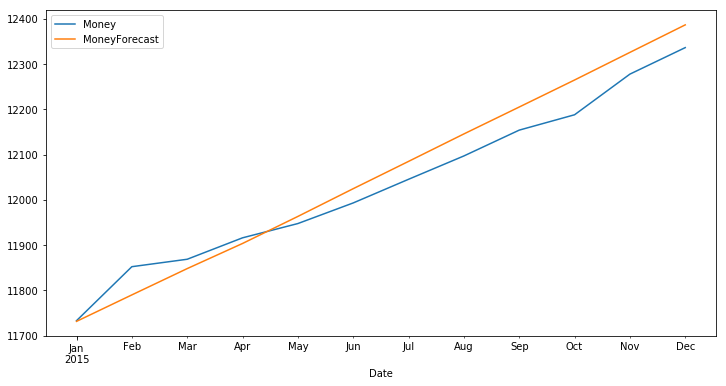

In [41]:
df['Money'][-nobs:].plot(figsize=(12, 6), legend=True)
df_forecast['MoneyForecast'].plot(legend=True)

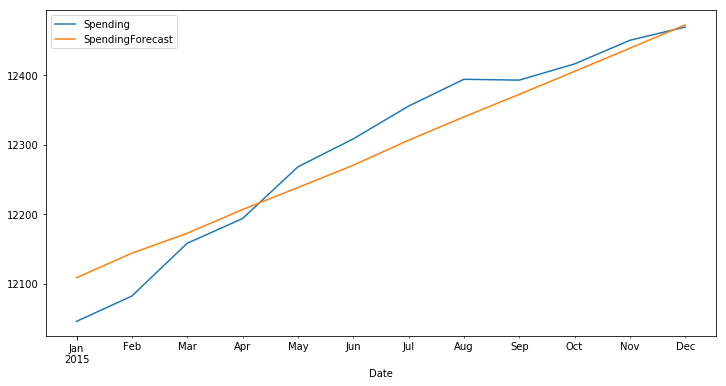

In [42]:
df['Spending'][-nobs:].plot(figsize=(12, 6), legend=True)
df_forecast['SpendingForecast'].plot(legend=True)

#### Evaluate model

In [44]:
rmse_money = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print('rmse_money {}'.format(round(rmse_money, 3)))

rmse_money 43.71


In [45]:
rmse_spending = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print('rmse_spending {}'.format(round(rmse_spending, 3)))

rmse_spending 37.001


In [54]:
test['Spending'].describe()

count    12.00000
mean      0.70000
std      32.96243
min     -40.40000
25%     -28.47500
50%      -0.80000
75%      28.07500
max      52.40000
Name: Spending, dtype: float64

In [55]:
test['Money'].describe()

count     12.000000
mean      -1.675000
std       42.659756
min     -102.800000
25%      -17.625000
50%        2.400000
75%       18.225000
max       56.100000
Name: Money, dtype: float64

 The RMSE values for both money and spending are within the std of the test data, so they are acceptable forecasting values.